# 项目介绍


*   背景介绍
*   数据集说明：
    * used_house_data.csv:原始数据集
    * data_latlng.csv:以上经过经纬度转换后
    * data_clean.csv:以上经过缺失值异常值处理后
    * data_code.csv:以上经过onehot后
    * data_code2.csv:
*   内容概述

 0.   人工预处理
 1.   数据预处理
 2.   数据异常检测
 3.   数据编码
 4.   特征选择
 5.   模型训练
 6.   模型分析
 
 注意：为避免经纬度转换耗费时间，直接从第五块模型x
* 替代模型和黑盒模型的R2还需要再计算一下

***此部分最后补充，作简要说明***


# 0、人工预处理 
主要内容
*   数据观察，确定分类变量与数值变量
*   数据集针对性操作
*   ...


In [1]:
#1225晚上，经纬度编码出现了问题
import os
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from hzy import data_duplicate, data_latlng, data_normalization, data_anomaly, data_encoding

%matplotlib inline
pd.set_option('display.max_columns', None)

In [2]:
data_name = 'used_house_data'
path = './Dataset/{0}/'.format(data_name)

data_raw = pd.read_csv(path+'{0}.csv'.format(data_name))
data_raw.head()

,ID,Region,Road,Community_Name,House_Type,Transaction_Time,Final_Price,Unit_Price,Listing_Price,Transaction_Cycle,Num_Price_Adjustment,Num_Look,Attention,Num_Browse,Floor,Construction_Area,Unit_Structure,Type_Structure,Oriented,Age,Renovation,Construction_struct,Ladder_Ratio,Property_Rights_Time,Elevator,Trading_Authority,Listing_Time,Housing_Purposes,House_Ownership,Year_Of_Housing,Storey,Ladder,Household,Num_Bedroom,Num_Hall
0,107100261662,浦东,三林,城林雅苑,1室1厅,2018-09-30,218.0,46502.0,235.0,149.0,1,4,9,1565.0,中,46.0,NaN,塔楼,南,2013.0,其他,钢混结构,一梯六户,NaN,有,动迁安置房,2018-05-05,普通住宅,非共有,NaN,28.0,1.0,6.0,1.0,1.0
1,107100668755,浦东,源深,盛世年华,3室2厅,2018-09-30,1620.0,107613.0,1680.0,8.0,0,4,8,252.0,中,150.0,NaN,板楼,南,2005.0,简装,钢混结构,两梯两户,NaN,有,商品房,2018-09-23,普通住宅,共有,NaN,32.0,2.0,2.0,3.0,2.0
2,107100566972,浦东,世博,雪野二村,2室1厅,2018-09-30,368.0,62089.0,380.0,43.0,1,1,0,NaN,低,59.0,平层,板楼,南,1986.0,精装,砖混结构,一梯四户,NaN,无,商品房,2018-08-19,普通住宅,非共有,NaN,6.0,1.0,4.0,2.0,1.0
3,107100390003,浦东,周浦,印象春城,2室2厅,2018-09-30,368.0,41242.0,388.0,105.0,1,18,167,6048.0,低,89.0,平层,板楼,南,2011.0,其他,钢混结构,两梯四户,NaN,有,商品房,2018-06-18,普通住宅,NaN,NaN,18.0,2.0,4.0,2.0,2.0
4,107100382965,浦东,康桥,双秀西园,2室2厅,2018-09-30,289.0,36125.0,310.0,108.0,1,0,25,2956.0,高,80.0,平层,板楼,南,2008.0,其他,钢混结构,一梯四户,NaN,有,动迁安置房,2018-06-15,普通住宅,共有,NaN,11.0,1.0,4.0,2.0,2.0


In [11]:
# From HZY

data_clean = data_raw.copy()
print('原始数据规格：'+str(data_clean.shape))

# 拼接
data_clean['Location'] = data_raw['Region']+data_raw['Road']+data_raw['Community_Name']

# 人工特征删除
cols = ['ID','Unit_Price','Listing_Price','Transaction_Time','Listing_Time','Region','Road','Community_Name','Num_Bedroom', 'Num_Hall']
data_clean.drop(cols,axis=1,inplace=True)
print('人工删除后：'+str(data_clean.shape))

# 去重
data_duplicate(data_clean)
print('数据去重后：'+str(data_clean.shape))

# 变量类型划分
# 用于：标准化、编码、异常处理
cols = {}
cols['num'] = ['Final_Price','Transaction_Cycle','Num_Price_Adjustment', 'Num_Look', 'Attention', 'Num_Browse', 'Construction_Area','Age','Storey', 'Ladder', 'Household','Year_Of_Housing','Property_Rights_Time']
cols['str'] = list(set(list(data_clean.columns)).difference(set(cols['num'])))

原始数据规格：(56126, 35)
人工删除后：(56126, 26)
数据去重后：(54557, 26)


In [12]:
cols['str']

['Elevator',
 'Construction_struct',
 'Ladder_Ratio',
 'Oriented',
 'House_Ownership',
 'House_Type',
 'Housing_Purposes',
 'Floor',
 'Trading_Authority',
 'Renovation',
 'Type_Structure',
 'Location',
 'Unit_Structure']

In [13]:
data_clean.head()

,House_Type,Final_Price,Transaction_Cycle,Num_Price_Adjustment,Num_Look,Attention,Num_Browse,Floor,Construction_Area,Unit_Structure,Type_Structure,Oriented,Age,Renovation,Construction_struct,Ladder_Ratio,Property_Rights_Time,Elevator,Trading_Authority,Housing_Purposes,House_Ownership,Year_Of_Housing,Storey,Ladder,Household,Location
0,1室1厅,218.0,149.0,1,4,9,1565.0,中,46.0,NaN,塔楼,南,2013.0,其他,钢混结构,一梯六户,NaN,有,动迁安置房,普通住宅,非共有,NaN,28.0,1.0,6.0,浦东三林城林雅苑
1,3室2厅,1620.0,8.0,0,4,8,252.0,中,150.0,NaN,板楼,南,2005.0,简装,钢混结构,两梯两户,NaN,有,商品房,普通住宅,共有,NaN,32.0,2.0,2.0,浦东源深盛世年华
2,2室1厅,368.0,43.0,1,1,0,NaN,低,59.0,平层,板楼,南,1986.0,精装,砖混结构,一梯四户,NaN,无,商品房,普通住宅,非共有,NaN,6.0,1.0,4.0,浦东世博雪野二村
3,2室2厅,368.0,105.0,1,18,167,6048.0,低,89.0,平层,板楼,南,2011.0,其他,钢混结构,两梯四户,NaN,有,商品房,普通住宅,NaN,NaN,18.0,2.0,4.0,浦东周浦印象春城
4,2室2厅,289.0,108.0,1,0,25,2956.0,高,80.0,平层,板楼,南,2008.0,其他,钢混结构,一梯四户,NaN,有,动迁安置房,普通住宅,共有,NaN,11.0,1.0,4.0,浦东康桥双秀西园


**注意：之后变更特征时，需在cols中也删除对应字段**

In [14]:
# 观察分类后的数据情况
data_clean[cols['num']].head()

,Final_Price,Transaction_Cycle,Num_Price_Adjustment,Num_Look,Attention,Num_Browse,Construction_Area,Age,Storey,Ladder,Household,Year_Of_Housing,Property_Rights_Time
0,218.0,149.0,1,4,9,1565.0,46.0,2013.0,28.0,1.0,6.0,NaN,NaN
1,1620.0,8.0,0,4,8,252.0,150.0,2005.0,32.0,2.0,2.0,NaN,NaN
2,368.0,43.0,1,1,0,NaN,59.0,1986.0,6.0,1.0,4.0,NaN,NaN
3,368.0,105.0,1,18,167,6048.0,89.0,2011.0,18.0,2.0,4.0,NaN,NaN
4,289.0,108.0,1,0,25,2956.0,80.0,2008.0,11.0,1.0,4.0,NaN,NaN


In [15]:
data_clean[cols['str']].head()

,Elevator,Construction_struct,Ladder_Ratio,Oriented,House_Ownership,House_Type,Housing_Purposes,Floor,Trading_Authority,Renovation,Type_Structure,Location,Unit_Structure
0,有,钢混结构,一梯六户,南,非共有,1室1厅,普通住宅,中,动迁安置房,其他,塔楼,浦东三林城林雅苑,NaN
1,有,钢混结构,两梯两户,南,共有,3室2厅,普通住宅,中,商品房,简装,板楼,浦东源深盛世年华,NaN
2,无,砖混结构,一梯四户,南,非共有,2室1厅,普通住宅,低,商品房,精装,板楼,浦东世博雪野二村,平层
3,有,钢混结构,两梯四户,南,NaN,2室2厅,普通住宅,低,商品房,其他,板楼,浦东周浦印象春城,平层
4,有,钢混结构,一梯四户,南,共有,2室2厅,普通住宅,高,动迁安置房,其他,板楼,浦东康桥双秀西园,平层


**房产数据的地理信息处理**<br>
转换后的数据保存在path+'data_latlng.csv'中,它与data_clean.csv的区别就是location一列变成了经纬度两列

转换时间太慢，54557条数据耗时：10813s = 2.8h

In [16]:
data_latlng(data_clean,'train',cols,path)

经纬度转换开始
Coding number is 5000
Coding number is 10000
Coding number is 15000
Coding number is 20000
Coding number is 25000
Coding number is 30000
Coding number is 35000
Coding number is 40000
Coding number is 45000
Coding number is 50000
转换后数据规格：(54557, 27)
耗时：8972.1785
经纬度转换结束


# 1、数据预处理 （王泽华、黄宗源）
主要内容：

    1）数据概述
    2）数据标准化
    3）缺失值处理




In [4]:
# 实验时使用，避免人工步骤和编码的重复进行
import os
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from hzy import data_duplicate, data_latlng, data_normalization, data_anomaly, data_encoding

%matplotlib inline
pd.set_option('display.max_columns', None)

data_name = 'used_house_data'
path = './Dataset/{0}/'.format(data_name)

data_clean = pd.read_csv(path+'data_latlng.csv')

cols = {}
cols['num'] = ['Final_Price','Transaction_Cycle','Num_Price_Adjustment', 'Num_Look', 'Attention', 'Num_Browse', 'Construction_Area','Storey', 'Ladder', 'Household','Year_Of_Housing','Property_Rights_Time','Latitude','Longitude']
cols['str'] = list(set(list(data_clean.columns)).difference(set(cols['num'])))

data_clean.head()

,House_Type,Final_Price,Transaction_Cycle,Num_Price_Adjustment,Num_Look,Attention,Num_Browse,Floor,Construction_Area,Unit_Structure,Type_Structure,Oriented,Age,Renovation,Construction_struct,Ladder_Ratio,Property_Rights_Time,Elevator,Trading_Authority,Housing_Purposes,House_Ownership,Year_Of_Housing,Storey,Ladder,Household,Longitude,Latitude
0,1室1厅,218.0,149.0,1,4,9,1565.0,中,46.0,NaN,塔楼,南,2013.0,其他,钢混结构,一梯六户,NaN,有,动迁安置房,普通住宅,非共有,NaN,28.0,1.0,6.0,121.514616,31.133690
1,3室2厅,1620.0,8.0,0,4,8,252.0,中,150.0,NaN,板楼,南,2005.0,简装,钢混结构,两梯两户,NaN,有,商品房,普通住宅,共有,NaN,32.0,2.0,2.0,121.545452,31.234944
2,2室1厅,368.0,43.0,1,1,0,NaN,低,59.0,平层,板楼,南,1986.0,精装,砖混结构,一梯四户,NaN,无,商品房,普通住宅,非共有,NaN,6.0,1.0,4.0,121.504486,31.187161
3,2室2厅,368.0,105.0,1,18,167,6048.0,低,89.0,平层,板楼,南,2011.0,其他,钢混结构,两梯四户,NaN,有,商品房,普通住宅,NaN,NaN,18.0,2.0,4.0,121.596303,31.122068
4,2室2厅,289.0,108.0,1,0,25,2956.0,高,80.0,平层,板楼,南,2008.0,其他,钢混结构,一梯四户,NaN,有,动迁安置房,普通住宅,共有,NaN,11.0,1.0,4.0,116.632891,40.329616


### 1.1 数据概述

@泽华：数据概述中需要统计各变量的数值个数，个数少的离散变量当分类变量用，不进行scaler<br>
调整cols['num']和cols['str'],用append和remove


In [ ]:
def data_overview():
  """
  param:
  return:
  function:
  """
  pass


In [146]:
# 根据数据概述结果，调整cols
col = ['Num_Price_Adjustment']   # 这个根据数据概述结果调整
for i in col:
    cols['num'].remove(i)
    cols['str'].append(i)

### 1.2 标准化

In [6]:
# 2.数据标准化
tmp = cols['num'].copy()         #或者使用deepcopy()
tmp.remove('Final_Price')        #目标值不标准化
data_normalization(data_clean,tmp)
data_clean[cols['num']].head()

,Final_Price,Transaction_Cycle,Num_Price_Adjustment,Num_Look,Attention,Num_Browse,Construction_Area,Storey,Ladder,Household,Year_Of_Housing,Property_Rights_Time,Latitude,Longitude
0,218.0,-0.061709,0.0,0.571429,0.125000,0.125998,-0.488372,2.000000,0.0,1.0,NaN,NaN,-0.895628,0.636212
1,1620.0,-0.284810,-1.0,0.571429,0.083333,-0.456522,1.930233,2.363636,1.0,-1.0,NaN,NaN,-0.024050,0.931556
2,368.0,-0.229430,0.0,0.142857,-0.250000,NaN,-0.186047,0.000000,0.0,0.0,NaN,NaN,-0.435358,0.539188
3,368.0,-0.131329,0.0,2.571429,6.708333,2.114907,0.511628,1.090909,1.0,0.0,NaN,NaN,-0.995668,1.418602
4,289.0,-0.126582,0.0,0.000000,0.791667,0.743123,0.302326,0.454545,0.0,0.0,NaN,NaN,78.261373,-46.120471


### 1.3 缺失值处理

In [7]:
data_clean.isnull().sum()

House_Type                281
Final_Price                 0
Transaction_Cycle           8
Num_Price_Adjustment        0
Num_Look                    0
Attention                   0
Num_Browse              22321
Floor                       0
Construction_Area           0
Unit_Structure          33366
Type_Structure            390
Oriented                 4338
Age                      3245
Renovation                  0
Construction_struct       301
Ladder_Ratio               56
Property_Rights_Time    37869
Elevator                 2415
Trading_Authority           0
Housing_Purposes            4
House_Ownership         26503
Year_Of_Housing         52231
Storey                      1
Ladder                     56
Household                  56
Longitude                  31
Latitude                   31
dtype: int64

In [8]:
def missing_value_processing(data,cols):
    """
    param:
    return:
    function:
    """
    # 特征删除
    cols_del = ['Year_Of_Housing','Unit_Structure','Num_Browse','House_Ownership','Property_Rights_Time']
    data.drop(cols_del,axis=1,inplace=True)
    cols['num'] = [x for x in cols['num'] if x not in cols_del]
    cols['str'] = [x for x in cols['str'] if x not in cols_del]
    
    # 数据删除
    data.dropna(inplace=True)
    data.reset_index(drop=True, inplace=True)
    print('删去后数据规格：'+str(data.shape))

# 暂时全部删去，等泽华修改
missing_value_processing(data_clean,cols)

删去后数据规格：(45634, 22)


In [9]:
data_clean.isnull().sum()

House_Type              0
Final_Price             0
Transaction_Cycle       0
Num_Price_Adjustment    0
Num_Look                0
Attention               0
Floor                   0
Construction_Area       0
Type_Structure          0
Oriented                0
Age                     0
Renovation              0
Construction_struct     0
Ladder_Ratio            0
Elevator                0
Trading_Authority       0
Housing_Purposes        0
Storey                  0
Ladder                  0
Household               0
Longitude               0
Latitude                0
dtype: int64

In [10]:
data_clean.to_csv(path+'data_clean.csv')

# 2、数据异常检测（黄宗源）
主要内容：


*   孤立森林处理异常
*   异常数据展示


In [11]:
# 函数统一格式见一
data_anomaly(data_clean,cols)

异常检测开始
异常检测后数据规格：(45634, 22)
耗时：0.0001
异常检测结束


# 3、数据编码（黄宗源）

数据编码，编码结果保存在path+'data.code.csv'中 <br>
因为数据量大，传值不便，故以文件形式传值

In [9]:
#data_encoding(data_clean,cols,path)

数据编码开始
编码后数据规格：(45653, 351)
耗时：10.1480
数据编码结束


In [18]:
def data_encoding_2(data,cols,path,target,m=300):
    '''
        param:
            m: is the weight of overall mean
        Info:
            Version 2, target encoding rather than onehot
            url: http://kodgv.xyz/2019/04/08/%E7%AB%9E%E8%B5%9B%E7%BB%8F%E9%AA%8C/targetencoding/

    '''

    print('数据编码开始')
    start=time.time()

    if 'str' in cols:
        for i in cols['str']:
            data.loc[:,i] = target_encoding(data,i,target,m)
        data.to_csv(path+'data_code2.csv',index=False)
        print('编码后数据规格：'+str(data.shape))

    end=time.time()
    print('耗时：%.4f' %(end-start))
    print('数据编码结束')


def target_encoding(data, group, target, m):
    # Compute the global mean
    mean = data[target].mean()

    # Compute the number of values and the mean of each group
    agg = data.groupby(group)[target].agg(['count', 'mean'])
    counts = agg['count']
    means = agg['mean']

    # Compute the "smoothed" means
    smooth = (counts * means + m * mean) / (counts + m)

    # Replace each value by the according smoothed mean
    return data[group].map(smooth)

In [20]:
import time
data_encoding_2(data_clean,cols,path,'Final_Price')

数据编码开始
编码后数据规格：(45634, 22)
耗时：2.0545
数据编码结束


## 4、特征选择（张健全）
主要内容：


*   B1
*   B2
*   ...

注 这部分主要使用sklearn库即可



In [10]:
# 这部分直接从编码后的数据开始实验

import pandas as pd
import numpy as np

data_name = 'used_house_data'
path = './Dataset/{0}/'.format(data_name)

data_code2 = pd.read_csv(path+'data_code2.csv')
data_code2.head()

,Final_Price,Transaction_Cycle,Num_Look,Attention,Construction_Area,Storey,Ladder,Household,Longitude,Latitude,x0_别墅,x0_商业办公类,x0_新式里弄,x0_旧式里弄,x0_普通住宅,x0_老公寓,x0_花园洋房,x1_东,x1_东 东南,x1_东 东南 北,x1_东 东南 南,x1_东 北,x1_东 南,x1_东 南 北,x1_东 南 西,x1_东 西,x1_东 西 北,x1_东北,x1_东南,x1_东南 东,x1_东南 东北,x1_东南 北,x1_东南 南,x1_东南 南 东北,x1_东南 南 北,x1_东南 南 西南,x1_东南 南 西南 北,x1_东南 西南,x1_北,x1_北 东北,x1_北 南,x1_北 西北,x1_北 西南,x1_南,x1_南 东,x1_南 东 北,x1_南 东北,x1_南 东南,x1_南 北,x1_南 北 西,x1_南 西,x1_南 西 北,x1_南 西北,x1_南 西北 北,x1_南 西南,x1_南 西南 北,x1_南 西南 西 北,x1_西,x1_西 东北,x1_西 北,x1_西 西北,x1_西北,x1_西北 东北,x1_西北 北,x1_西南,x1_西南 北,x1_西南 西,x1_西南 西北,x2_中,x2_低,x2_地下室,x2_高,x3_框架结构,x3_混合结构,x3_砖混结构,x3_钢混结构,x4_一梯一户,x4_一梯七十九户,x4_一梯七户,x4_一梯三十三户,x4_一梯三十二户,x4_一梯三十六户,x4_一梯三十四户,x4_一梯三十户,x4_一梯三户,x4_一梯两户,x4_一梯九十六户,x4_一梯九户,x4_一梯二十一户,x4_一梯二十七户,x4_一梯二十三户,x4_一梯二十九户,x4_一梯二十五户,x4_一梯二十六户,x4_一梯二十四户,x4_一梯二十户,x4_一梯五户,x4_一梯八十户,x4_一梯八户,x4_一梯六十八户,x4_一梯六十户,x4_一梯六户,x4_一梯十一户,x4_一梯十七户,x4_一梯十三户,x4_一梯十二户,x4_一梯十五户,x4_一梯十八户,x4_一梯十六户,x4_一梯十四户,x4_一梯十户,x4_一梯四十三户,x4_一梯四十九户,x4_一梯四户,x4_三梯一户,x4_三梯七十七户,x4_三梯七户,x4_三梯三十七户,x4_三梯三十四户,x4_三梯三户,x4_三梯两户,x4_三梯九户,x4_三梯二十二户,x4_三梯二十六户,x4_三梯二十四户,x4_三梯二十户,x4_三梯五十一户,x4_三梯五户,x4_三梯八户,x4_三梯六户,x4_三梯十一户,x4_三梯十七户,x4_三梯十三户,x4_三梯十九户,x4_三梯十二户,x4_三梯十五户,x4_三梯十八户,x4_三梯十六户,x4_三梯十四户,x4_三梯十户,x4_三梯四户,x4_两梯一户,x4_两梯七户,x4_两梯三十七户,x4_两梯三十五户,x4_两梯三十四户,x4_两梯三户,x4_两梯两户,x4_两梯九户,x4_两梯二十一户,x4_两梯二十三户,x4_两梯二十五户,x4_两梯二十八户,x4_两梯二十四户,x4_两梯二十户,x4_两梯五户,x4_两梯八户,x4_两梯六户,x4_两梯十一户,x4_两梯十七户,x4_两梯十三户,x4_两梯十九户,x4_两梯十二户,x4_两梯十五户,x4_两梯十八户,x4_两梯十六户,x4_两梯十四户,x4_两梯十户,x4_两梯四户,x4_九梯两户,x4_五梯三十一户,x4_五梯三十四户,x4_五梯二十一户,x4_五梯二十五户,x4_五梯二十六户,x4_五梯二十四户,x4_五梯八户,x4_五梯十一户,x4_五梯十三户,x4_五梯十九户,x4_五梯十八户,x4_五梯十户,x4_五梯四户,x4_八梯十二户,x4_六梯三十二户,x4_六梯二十八户,x4_六梯二十四户,x4_六梯八户,x4_六梯六户,x4_六梯十户,x4_六梯四户,x4_四梯七户,x4_四梯三十三户,x4_四梯三十户,x4_四梯三户,x4_四梯两户,x4_四梯九户,x4_四梯二十一户,x4_四梯二十二户,x4_四梯二十五户,x4_四梯二十六户,x4_四梯二十四户,x4_四梯二十户,x4_四梯五户,x4_四梯八户,x4_四梯六户,x4_四梯十七户,x4_四梯十三户,x4_四梯十九户,x4_四梯十二户,x4_四梯十五户,x4_四梯十八户,x4_四梯十六户,x4_四梯十四户,x4_四梯十户,x4_四梯四户,x5_其他,x5_毛坯,x5_简装,x5_精装,x6_1911.0,x6_1912.0,x6_1920.0,x6_1924.0,x6_1926.0,x6_1928.0,x6_1930.0,x6_1931.0,x6_1935.0,x6_1936.0,x6_1937.0,x6_1939.0,x6_1940.0,x6_1941.0,x6_1942.0,x6_1943.0,x6_1947.0,x6_1948.0,x6_1949.0,x6_1950.0,x6_1952.0,x6_1953.0,x6_1954.0,x6_1955.0,x6_1956.0,x6_1957.0,x6_1958.0,x6_1959.0,x6_1960.0,x6_1961.0,x6_1962.0,x6_1963.0,x6_1964.0,x6_1965.0,x6_1966.0,x6_1967.0,x6_1968.0,x6_1969.0,x6_1970.0,x6_1972.0,x6_1973.0,x6_1974.0,x6_1975.0,x6_1976.0,x6_1977.0,x6_1978.0,x6_1979.0,x6_1980.0,x6_1981.0,x6_1982.0,x6_1983.0,x6_1984.0,x6_1985.0,x6_1986.0,x6_1987.0,x6_1988.0,x6_1989.0,x6_1990.0,x6_1991.0,x6_1992.0,x6_1993.0,x6_1994.0,x6_1995.0,x6_1996.0,x6_1997.0,x6_1998.0,x6_1999.0,x6_2000.0,x6_2001.0,x6_2002.0,x6_2003.0,x6_2004.0,x6_2005.0,x6_2006.0,x6_2007.0,x6_2008.0,x6_2009.0,x6_2010.0,x6_2011.0,x6_2012.0,x6_2013.0,x6_2014.0,x6_2015.0,x6_2016.0,x6_2017.0,x6_2018.0,x7_塔楼,x7_平房,x7_板塔结合,x7_板楼,x8_1室0厅,x8_1室1厅,x8_1室2厅,x8_1室3厅,x8_2室0厅,x8_2室1厅,x8_2室2厅,x8_2室3厅,x8_3室0厅,x8_3室1厅,x8_3室2厅,x8_3室3厅,x8_4室0厅,x8_4室1厅,x8_4室2厅,x8_4室3厅,x8_4室4厅,x8_5室0厅,x8_5室1厅,x8_5室2厅,x8_5室3厅,x8_5室4厅,x8_6室1厅,x8_6室2厅,x8_6室3厅,x8_6室4厅,x8_6室5厅,x8_6室6厅,x8_7室1厅,x8_7室2厅,x8_7室3厅,x8_8室2厅,x8_9室3厅,x9_使用权,x9_动迁安置房,x9_售后公房,x9_商品房,x10_无,x10_有,x11_0,x11_1
0,218.0,-0.061709,0.571429,0.125000,-0.488372,2.000000,0.0,1.0,0.636557,-0.895668,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [ ]:
# 函数统一格式见一
# 主要参考sklearn.feature_selection中的处理方法，具体使用说明官网有详细教程
import sklearn.feature_selection

# 5、模型训练（胡博文、李瑞）
主要内容：


*   C1
*   C2
*   ...



In [69]:
# 函数格式见一
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics
import time

pd.set_option('display.max_columns',None) #完整显示整行
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号

In [70]:
dataset = pd.read_csv('Dataset/used_house_data/data_code2.csv')

In [71]:
#将Final_price提到第一列
final_price=dataset['Final_Price']
dataset.drop('Final_Price',axis=1,inplace=True)
dataset.insert(0,'Final_Price',final_price)

In [72]:
dataset.head(10)

,Final_Price,House_Type,Transaction_Cycle,Num_Price_Adjustment,Num_Look,Attention,Floor,Construction_Area,Type_Structure,Oriented,Age,Renovation,Construction_struct,Ladder_Ratio,Elevator,Trading_Authority,Housing_Purposes,Storey,Ladder,Household,Longitude,Latitude
0,218.0,235.000465,-0.061709,0.0,0.571429,0.125000,397.120765,-0.488372,469.410066,395.602376,368.165431,416.097667,527.097733,268.537479,572.492753,294.023742,392.505308,2.000000,0.0,1.0,0.636212,-0.895628
1,1620.0,692.694302,-0.284810,-1.0,0.571429,0.083333,397.120765,1.930233,392.308080,395.602376,573.183061,308.914676,527.097733,1029.912432,572.492753,407.894785,392.505308,2.363636,1.0,-1.0,0.931556,-0.024050
2,368.0,304.067290,-0.229430,0.0,0.142857,-0.250000,437.387352,-0.186047,392.308080,395.602376,278.769040,450.731709,255.154694,256.437791,287.893067,407.894785,392.505308,0.000000,0.0,0.0,0.539188,-0.435358
3,368.0,490.121196,-0.131329,0.0,2.571429,6.708333,437.387352,0.511628,392.308080,395.602376,440.524822,416.097667,527.097733,553.311941,572.492753,407.894785,392.505308,1.090909,1.0,0.0,1.418602,-0.995668
4,289.0,490.121196,-0.126582,0.0,0.000000,0.791667,375.414667,0.302326,392.308080,395.602376,474.324261,416.097667,527.097733,256.437791,572.492753,294.023742,392.505308,0.454545,0.0,0.0,-46.120471,78.261373
5,360.0,692.694302,-0.140823,0.0,0.285714,1.916667,375.414667,0.906977,392.308080,395.602376,572.481390,416.097667,527.097733,299.766107,287.893067,407.894785,392.505308,0.000000,0.0,-0.5,-44.195274,78.722408
6,775.0,692.694302,-0.049051,0.0,0.285714,1.708333,375.414667,1.418605,392.308080,395.602376,616.167922,308.914676,527.097733,379.106244,572.492753,407.894785,392.505308,0.454545,0.0,-1.0,3.330026,-2.141913
7,219.0,235.000465,0.623418,0.0,0.000000,2.125000,437.387352,-0.418605,392.308080,395.602376,573.183061,450.731709,527.097733,379.106244,287.893067,407.894785,392.505308,0.000000,0.0,-1.0,2.166933,0.373055
8,331.0,692.694302,-0.254747,0.0,0.142857,0.500000,397.120765,1.325581,392.308080,395.602376,440.524822,416.097667,527.097733,379.106244,572.492753,407.894785,392.505308,0.545455,0.0,-1.0,2.460640,-0.364593
9,610.0,490.121196,1.006329,0.0,0.857143,2.250000,437.387352,0.837209,392.308080,395.602376,527.903235,335.070061,527.097733,706.465005,572.492753,407.894785,392.505308,1.090909,1.0,-0.5,1.288084,-0.638710


In [73]:
data_array=dataset.loc[:].values

In [76]:
# 提取数据标签
train_X=dataset.drop(["Final_Price"],axis=1)
train_y=dataset["Final_Price"].values
# 划分测试集和训练集
seed=0
test_size=0.33
X_train, X_test, y_train, y_test=train_test_split(train_X,train_y,test_size=test_size,random_state=seed)

print('训练集数据大小 {} \n测试集数据大小 {}'.format(X_train.shape, X_test.shape))

训练集数据大小 (30574, 21) 
测试集数据大小 (15060, 21)


In [77]:
# 
stat_list = []

### 5.1 XGBoost

In [78]:
import xgboost as xgb
from xgboost import XGBRegressor
from xgboost import plot_importance

[21:43:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


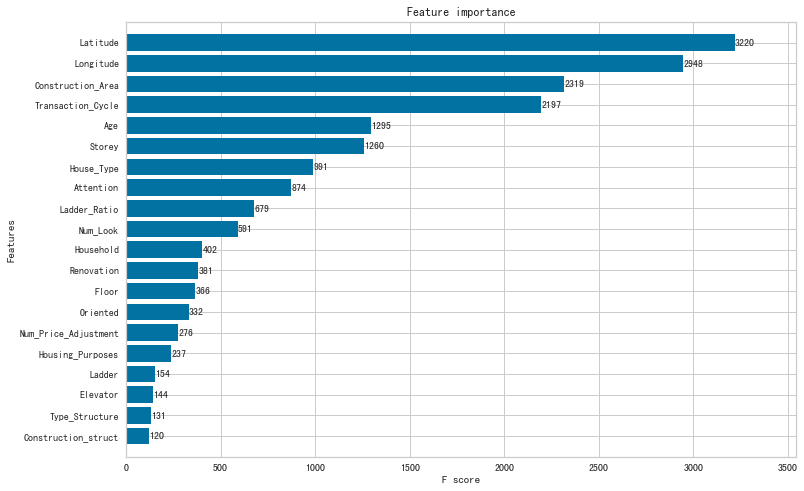

In [79]:


xgb_params = {
    'eta':0.05,
    'max_depth':8,
    'subsample':0.7,
    'colsample_bytree':0.7,
    'objective':'reg:linear',
    'eval_metric':'rmse',
    'silent':0
}
dtrain=xgb.DMatrix(train_X,train_y,feature_names=train_X.columns.values)
model=xgb.train(dict(xgb_params,silent=0),dtrain,num_boost_round=100)

fig,ax = plt.subplots(figsize=(12,8))
xgb.plot_importance(model,max_num_features=20,height=0.8,ax=ax)

In [84]:
model_xgb=XGBRegressor()
model_xgb.fit(X_train,y_train)

[21:50:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [85]:
y_pred_xgb=model_xgb.predict(X_test)
predictions_xgb=[round(value)for value in y_pred_xgb]

In [86]:
MSE_xgb=metrics.mean_squared_error(y_test,predictions_xgb)
R2_xgb=metrics.r2_score(y_test,predictions_xgb)
MAE_xgb=metrics.mean_absolute_error(y_test,predictions_xgb)
print("模型测试结果：\nMSE: {:.3f}\nRMSE: {:.3f}\nR2: {:.3f}\nMAE: {:.3f}".format(MSE_xgb,
                                                                          np.sqrt(MSE_xgb),
                                                                          R2_xgb,
                                                                          MAE_xgb))
stat_list.append([MSE_xgb, np.sqrt(MSE_xgb), R2_xgb, MAE_xgb])

模型测试结果：
MSE: 21127.050
RMSE: 145.351
R2: 0.825
MAE: 84.949


In [87]:
print(y_pred_xgb[0:10])
print(y_test[0:10])

[189.06343 357.03546 720.1288  103.7961  481.70093 175.08464 925.34
 327.60504 264.8025  307.05228]
[ 189.  358.  787.    9.  450.  125. 1200.  375.  225.  250.]


In [88]:
# 保存模型
import joblib
import os
#os.mkdir('Model')
joblib.dump(model_xgb,'Model/model_xgb.pkl')

['Model/model_xgb.pkl']

### 5.2 Bayesian Ridge Regression

In [89]:
from sklearn import linear_model

In [90]:
model_bayes=linear_model.BayesianRidge()
model_bayes.fit(X_train,y_train)

BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=False, copy_X=True,
              fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
              normalize=False, tol=0.001, verbose=False)

In [91]:
y_pred_bayes=model_bayes.predict(X_test)
predictions_bayes=[round(value)for value in y_pred_bayes]

In [92]:
MSE_bayes=metrics.mean_squared_error(y_test,predictions_bayes)
R2_bayes=metrics.r2_score(y_test,predictions_bayes)
MAE_bayes=metrics.mean_absolute_error(y_test,predictions_bayes)
print("模型测试结果：\nMSE: {:.3f}\nRMSE: {:.3f}\nR2: {:.3f}\nMAE: {:.3f}".format(MSE_bayes,
                                                                          np.sqrt(MSE_bayes),
                                                                          R2_bayes,
                                                                          MAE_bayes))
stat_list.append([MSE_bayes, np.sqrt(MSE_bayes), R2_bayes, MAE_bayes])

模型测试结果：
MSE: 41162.077
RMSE: 202.884
R2: 0.658
MAE: 133.004


In [93]:
print(y_pred_bayes[0:10])
print(y_test[0:10])

[265.10237844 295.83084669 665.17608344 121.5863853  273.43108911
  90.27740504 842.20421994 180.67215057 314.10997397 207.86936052]
[ 189.  358.  787.    9.  450.  125. 1200.  375.  225.  250.]


In [94]:
# 保存模型
import joblib
joblib.dump(model_bayes,'Model/model_bayes.pkl')

['Model/model_bayes.pkl']

### 5.3 Lasso Regression

In [95]:
from sklearn import linear_model

In [96]:
model_lasso=linear_model.Lasso()
model_lasso.fit(X_train,y_train)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [97]:
y_pred_lasso=model_lasso.predict(X_test)
predictions_lasso=[round(value)for value in y_pred_lasso]

In [98]:
MSE_lasso=metrics.mean_squared_error(y_test,predictions_lasso)
R2_lasso=metrics.r2_score(y_test,predictions_lasso)
MAE_lasso=metrics.mean_absolute_error(y_test,predictions_lasso)
print("模型测试结果：\nMSE: {:.3f}\nRMSE: {:.3f}\nR2: {:.3f}\nMAE: {:.3f}".format(MSE_lasso,
                                                                          np.sqrt(MSE_lasso),
                                                                          R2_lasso,
                                                                          MAE_lasso))

stat_list.append([MSE_lasso, np.sqrt(MSE_lasso), R2_lasso, MAE_lasso])

模型测试结果：
MSE: 41125.171
RMSE: 202.793
R2: 0.658
MAE: 132.946


In [99]:
# 保存模型
import joblib
joblib.dump(model_lasso,'Model/model_lasso.pkl')

['Model/model_lasso.pkl']

### 5.4 Support Vector Machine

In [100]:
from sklearn import svm

In [101]:
model_svm=svm.SVR()
model_svm.fit(X_train,y_train)

The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.


SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)

In [102]:
y_pred_svm=model_svm.predict(X_test)
predictions_svm=[round(value)for value in y_pred_svm]

In [103]:
MSE_svm=metrics.mean_squared_error(y_test,predictions_svm)
R2_svm=metrics.r2_score(y_test,predictions_svm)
MAE_svm=metrics.mean_absolute_error(y_test,predictions_svm)
print("模型测试结果：\nMSE: {:.3f}\nRMSE: {:.3f}\nR2: {:.3f}\nMAE: {:.3f}".format(MSE_svm,
                                                                          np.sqrt(MSE_svm),
                                                                          R2_svm,
                                                                          MAE_svm))

stat_list.append([MSE_svm, np.sqrt(MSE_svm), R2_svm, MAE_svm])

模型测试结果：
MSE: 128494.395
RMSE: 358.461
R2: -0.067
MAE: 204.805


In [104]:
# 保存模型
import joblib
joblib.dump(model_svm,'Model/model_svm.pkl')

['Model/model_svm.pkl']

### 5.5  Gradient Tree Boosting

In [105]:
from sklearn.ensemble import GradientBoostingRegressor

In [106]:
model_gtb = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1,
                                      max_depth=1, random_state=0, loss='ls').fit(X_train,y_train)

In [107]:
y_pred_gtb=model_gtb.predict(X_test)
predictions_gtb=[round(value)for value in y_pred_gtb]

In [108]:
MSE_gtb=metrics.mean_squared_error(y_test,predictions_gtb)
R2_gtb=metrics.r2_score(y_test,predictions_gtb)
MAE_gtb=metrics.mean_absolute_error(y_test,predictions_gtb)

print("模型测试结果：\nMSE: {:.3f}\nRMSE: {:.3f}\nR2: {:.3f}\nMAE: {:.3f}".format(MSE_gtb,
                                                                          np.sqrt(MSE_gtb),
                                                                          R2_gtb,
                                                                          MAE_gtb))

stat_list.append([MSE_gtb, np.sqrt(MSE_gtb), R2_gtb, MAE_gtb])

模型测试结果：
MSE: 35557.381
RMSE: 188.567
R2: 0.705
MAE: 114.339


In [109]:
import joblib
joblib.dump(model_gtb,'Model/model_gtb.pkl')

['Model/model_gtb.pkl']

### 5.6  Bagging Regressor

In [110]:
from sklearn.ensemble import BaggingRegressor

In [111]:
model_bagging=BaggingRegressor()
model_bagging.fit(X_train,y_train)

BaggingRegressor(base_estimator=None, bootstrap=True, bootstrap_features=False,
                 max_features=1.0, max_samples=1.0, n_estimators=10,
                 n_jobs=None, oob_score=False, random_state=None, verbose=0,
                 warm_start=False)

In [112]:
y_pred_bagging=model_bagging.predict(X_test)
predictions_bagging=[round(value)for value in y_pred_bagging]

In [113]:
MSE_bagging=metrics.mean_squared_error(y_test,predictions_bagging)
R2_bagging=metrics.r2_score(y_test,predictions_bagging)
MAE_bagging=metrics.mean_absolute_error(y_test,predictions_bagging)

print("模型测试结果：\nMSE: {:.3f}\nRMSE: {:.3f}\nR2: {:.3f}\nMAE: {:.3f}".format(MSE_bagging,
                                                                          np.sqrt(MSE_bagging),
                                                                          R2_bagging,
                                                                          MAE_bagging))


模型测试结果：
MSE: 17539.403
RMSE: 132.436
R2: 0.854
MAE: 70.186


In [114]:
stat_list.append([MSE_bagging, np.sqrt(MSE_bagging), R2_bagging, MAE_bagging])

In [115]:
import joblib
joblib.dump(model_bagging,'Model/model_bagging.pkl')

['Model/model_bagging.pkl']

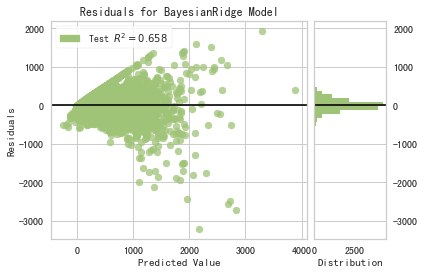

In [116]:
# 模型可视化模块

# 1.模型残差图
from yellowbrick.regressor import ResidualsPlot

def residuals_plot(model, X_test, y_test):
    """
    param 
    model : 已训练好的模型
    X_test : 测试集数据
    y_test : 测试集标签
    """
    visualizer = ResidualsPlot(model)
    visualizer.score(X_test, y_test)
    visualizer.poof()

residuals_plot(model_bayes, X_test, y_test)
    

# 6、模型分析（黄志为）
主要内容：


*   D1
*   D2
*   ...

任重而道远


In [ ]:
# 函数统一格式见一

### shap

In [64]:
#现在已经有了data_code2.csv，不再使用onehot，而是使用target encoding
#计算shap值的话，需要运行第5部分，得到模型，以及相应的训练数据
import shap

In [117]:
model_path=os.getcwd() + '/Model/model_bagging.pkl'
joblib.load(model_path)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [121]:
# visualize the first prediction's explanation
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:])

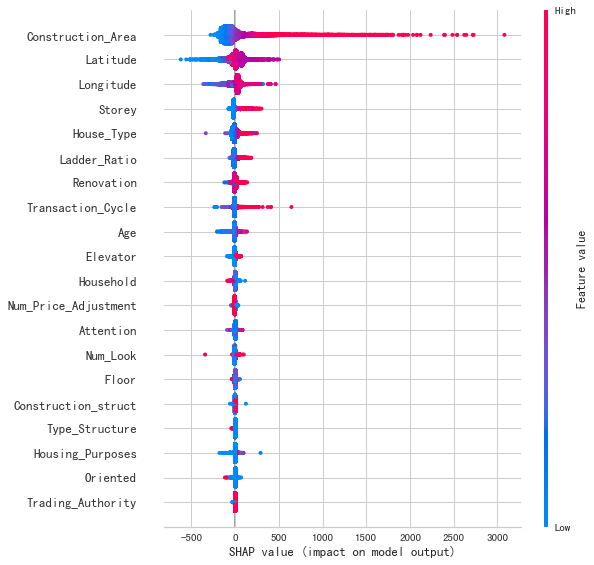

In [120]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X_train)

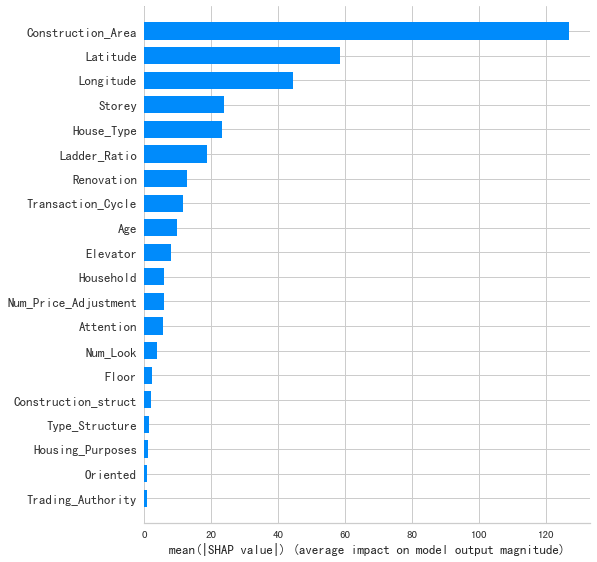

In [123]:
shap.summary_plot(shap_values, X_train,plot_type='bar')

### globalsurrogate

data_clean为targetencoding前的数据，data_code2为targetencoding后的数据

In [124]:
from sklearn.preprocessing import RobustScaler,OneHotEncoder
from math import log,pow

In [ ]:
data_code2 = pd.read_csv(path+'data_code2.csv')

In [127]:
data_code2.columns

Index(['Final_Price', 'House_Type', 'Transaction_Cycle',
       'Num_Price_Adjustment', 'Num_Look', 'Attention', 'Floor',
       'Construction_Area', 'Type_Structure', 'Oriented', 'Age', 'Renovation',
       'Construction_struct', 'Ladder_Ratio', 'Elevator', 'Trading_Authority',
       'Housing_Purposes', 'Storey', 'Ladder', 'Household', 'Longitude',
       'Latitude'],
      dtype='object')

In [132]:
data_clean=pd.read_csv(path+'data_clean.csv').drop('Unnamed: 0',axis=1)

In [133]:
data_clean.columns

Index(['House_Type', 'Final_Price', 'Transaction_Cycle',
       'Num_Price_Adjustment', 'Num_Look', 'Attention', 'Floor',
       'Construction_Area', 'Type_Structure', 'Oriented', 'Age', 'Renovation',
       'Construction_struct', 'Ladder_Ratio', 'Elevator', 'Trading_Authority',
       'Housing_Purposes', 'Storey', 'Ladder', 'Household', 'Longitude',
       'Latitude'],
      dtype='object')

In [134]:
data_clean.head()

,House_Type,Final_Price,Transaction_Cycle,Num_Price_Adjustment,Num_Look,Attention,Floor,Construction_Area,Type_Structure,Oriented,Age,Renovation,Construction_struct,Ladder_Ratio,Elevator,Trading_Authority,Housing_Purposes,Storey,Ladder,Household,Longitude,Latitude
0,1室1厅,218.0,-0.061709,0.0,0.571429,0.125000,中,-0.488372,塔楼,南,2013.0,其他,钢混结构,一梯六户,有,动迁安置房,普通住宅,2.000000,0.0,1.0,0.636212,-0.895628
1,3室2厅,1620.0,-0.284810,-1.0,0.571429,0.083333,中,1.930233,板楼,南,2005.0,简装,钢混结构,两梯两户,有,商品房,普通住宅,2.363636,1.0,-1.0,0.931556,-0.024050
2,2室1厅,368.0,-0.229430,0.0,0.142857,-0.250000,低,-0.186047,板楼,南,1986.0,精装,砖混结构,一梯四户,无,商品房,普通住宅,0.000000,0.0,0.0,0.539188,-0.435358
3,2室2厅,368.0,-0.131329,0.0,2.571429,6.708333,低,0.511628,板楼,南,2011.0,其他,钢混结构,两梯四户,有,商品房,普通住宅,1.090909,1.0,0.0,1.418602,-0.995668
4,2室2厅,289.0,-0.126582,0.0,0.000000,0.791667,高,0.302326,板楼,南,2008.0,其他,钢混结构,一梯四户,有,动迁安置房,普通住宅,0.454545,0.0,0.0,-46.120471,78.261373


In [215]:
#onehot时才run
# if not os.path.exists('User_data'):
#     os.mkdir('User_data')
# path_user='./User_data/'
# def Code_Count(data,cols):
#     '''
#          input:
#             data:used_house_data.csv
#         Ouput:
#             file:  ./User_data/columns.csv
#     '''
#     data_c=pd.DataFrame()      # data_count
#     # General
#     for i in cols['str']:
#         data_c.loc[0,i]=len(data[i].unique())
#         #data_c.loc[0,i]=1
#     for i in cols['num']:
#         data_c.loc[0,i]=1
#     data_c.loc[0,'Longitude']=1
#     data_c.loc[0,'Latitude']=1

#     data_c.to_csv(path_user+'/columns.csv',index=False)
    
# Code_Count(data_clean,cols)#生成columns.csv,这里应该是data_clean

In [99]:
#onehot才run
#     def Code(data):#对用户输入进行编码,这部分有待商榷，因为如何单独对输入进行编码的话，得到的是与数据集编码不一样的编码规则
#         print('输入编码开始')
#         #path = os.getcwd() + '/Dataset/used_house_data/used_house_data.csv'
#         start=time.time()
#         onehot = OneHotEncoder()
#         tmp_matrix = onehot.fit_transform(data.select_dtypes(include=[object])).toarray()
#         data_category = pd.DataFrame(tmp_matrix,columns=onehot.get_feature_names())
#         data_numerical=pd.DataFrame(RobustScaler().fit_transform(data.select_dtypes(exclude=[object])),columns=cols['num'])#这里的cols['num']直接从第一个cell调用
#         #data.drop(cols['str'], axis=1, inplace=True)
#         data = pd.concat([data,data_category], axis=1)
#         data.drop(data.select_dtypes(include=[object]).columns,axis=1,inplace=True)
#         data.to_csv(path_user+'user_code_data.csv',index=False)
#         end=time.time()
#         print('输入编码结束')

In [140]:
    def createLabel(finalPrice, criterion):
        """
        finalPrice:价格
        criterion:分档标准（List）
        return:根据价格给出一个整数，表示其价格档次
        """
        for i in range(len(criterion) + 1):
            if i == 0:
                if(finalPrice <= criterion[i]):
                    return i
            elif i == (len(criterion)):
                if(finalPrice > criterion[(len(criterion) - 1)]):
                    return i
            else:
                if(finalPrice > criterion[i - 1] and finalPrice <= criterion[i]):
                    return i
        
    def getData(userData_pred):
        """
        获取解释用数据集
        userData_pred:用户输入数据的预测值
        return:全局解释用数据子集
        step：1.对数据集进行标记（根据价格分档）
              2.取出与userData的预测值一档的数据集返回
        """
        path = os.getcwd() + '/Dataset/used_house_data/data_code2.csv'
        X = pd.read_csv(path)
        label = list(X['Final_Price'].quantile([0.15, 0.3, 0.45, 0.6, 0.75, 0.9]))
        X_label = X
        # X_label 增加一列label，表示依据价格对数据的分档，相当于对finalprice做了一个小小的特征工程
        X_label['Label'] = X_label.loc[:, 'Final_Price'].apply(createLabel, criterion=label)
        subX = X_label[X_label.Label == createLabel(userData_pred, criterion=label)]
        return subX

In [163]:
    def globalSurrogate(userData, model):
        """
        userData:用户输入数据,dataframe
        model:模型选择（String：bagging、xgb等）
        address:数据类型（房（house）、车（car））
        """
        model_path = os.getcwd() + '/Model/model_' +model+ '.pkl'
        columns_path = path_user+'columns.csv'
        model = joblib.load(model_path)#黑盒模型
        feature_ratio_list=[]
        #Code(userData)#path接上面第一个cell
        #CodeUserData = pd.read_csv(path_user+'user_code_data.csv')
        #price=model.predict(CodeUserData)
        coef_list=[]
        for i in range(len(userData.index)):
            data = getData(userData_pred=userData.iloc[i,0])
            #训练解释模型g,这里选取线性回归模型作为解释模型
            X=data.drop(['Final_Price','Label'],axis=1)
            print(X.columns)
            print(X.shape)
            y=data['Final_Price']
            g = linear_model.LinearRegression(fit_intercept=False)#fit_intercept=False表示不会在计算中使用截距，意思就是完全是正比例函数y=kx，不是一次函数y=kx+b         
            g.fit(X, y)
            coef_list.append(g.coef_)
        return coef_list
            #处理每个feature的权重
#             feature_columns = pd.read_csv(columns_path)
#             feature_ratio = dict()
#             index = 0
#             for key, value in dict(feature_columns).items():
#                 feature_ratio[key] = g.coef_[index]
#                 index += int(value)
#             # 调整显示结果
#             for key, value in feature_ratio.items():
#                 ans = log(abs(value + 0.01)) if value>0 else - log(abs(value + 0.01))
#                 feature_ratio[key] = round(ans, 3)
#             feature_ratio_list.append(feature_ratio)
#         df_feature_ratio=pd.DataFrame(feature_ratio_list).mean()
#         return df_feature_ratio

In [144]:
userData = data_code2.iloc[:1, :]
userData

,Final_Price,House_Type,Transaction_Cycle,Num_Price_Adjustment,Num_Look,Attention,Floor,Construction_Area,Type_Structure,Oriented,Age,Renovation,Construction_struct,Ladder_Ratio,Elevator,Trading_Authority,Housing_Purposes,Storey,Ladder,Household,Longitude,Latitude
0,218.0,235.000465,-0.061709,0.0,0.571429,0.125,397.120765,-0.488372,469.410066,395.602376,368.165431,416.097667,527.097733,268.537479,572.492753,294.023742,392.505308,2.0,0.0,1.0,0.636212,-0.895628


In [164]:
#目前问题，columns.csv除了问题，即code_count部分，需要用到data_clean.csv，但是前面没有封装
result=globalSurrogate(userData,'bagging')
print(result)

Index(['House_Type', 'Transaction_Cycle', 'Num_Price_Adjustment', 'Num_Look',
       'Attention', 'Floor', 'Construction_Area', 'Type_Structure', 'Oriented',
       'Age', 'Renovation', 'Construction_struct', 'Ladder_Ratio', 'Elevator',
       'Trading_Authority', 'Housing_Purposes', 'Storey', 'Ladder',
       'Household', 'Longitude', 'Latitude'],
      dtype='object')
(6855, 21)
[array([-2.13521560e-03,  1.21637366e+00, -1.01572517e-01, -9.59933719e-02,
       -9.99883861e-02,  1.49230023e-02,  1.96443608e+00,  8.80261032e-03,
        3.84476759e-02,  8.61757219e-03,  4.47781699e-03,  4.62384985e-03,
       -2.25971674e-05,  3.79736623e-03, -1.34796638e-04,  4.34246994e-01,
        3.85145964e+00, -2.51947199e+00, -3.72514409e-01,  2.55542750e-01,
        1.79133625e-01])]


In [165]:
df_result=pd.DataFrame(result,columns=userData.drop('Final_Price',axis=1).columns)

In [1]:
df_result

NameError: name 'df_result' is not defined

# Contribution
后期整合